In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from pycaret.classification import setup, evaluate_model, compare_models, plot_model
import optuna

# Load Data

In [2]:
train = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [3]:
train.shape

(414, 7)

In [4]:
train.head()

,gravity,ph,osmo,cond,urea,calc,target
id,,,,,,,
0,1.013,6.19,443,14.8,124,1.45,0
1,1.025,5.40,703,23.6,394,4.18,0
2,1.009,6.13,371,24.5,159,9.04,0
3,1.021,4.91,442,20.8,398,6.63,1
4,1.021,5.53,874,17.8,385,2.21,1


In [5]:
train.target.value_counts()

0    230
1    184
Name: target, dtype: int64

In [6]:
X = train.drop(['gravity', 'ph', 'osmo', 'urea', 'target'], axis=1).copy()
y = train.target

# Base Model

In [7]:
rf = RandomForestClassifier(random_state=0)

results = []

kf = KFold(n_splits=10, shuffle=True, random_state=0)

r = cross_val_score(rf, X, y, scoring='roc_auc')

results.append(r)

print(f'ROC score: {np.mean(results).round(2)}')

ROC score: 0.72


# Model Selection

In [8]:
_ = setup(data=train, target='target')

,Description,Value
0,session_id,4973
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(414, 7)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [9]:
best = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7443,0.8016,0.6468,0.7462,0.6859,0.4738,0.4825,0.1630
lda,Linear Discriminant Analysis,0.7446,0.7982,0.5846,0.7873,0.6659,0.4674,0.4845,0.0030
lr,Logistic Regression,0.7584,0.7939,0.6077,0.8081,0.6887,0.4975,0.5152,0.4200
gbc,Gradient Boosting Classifier,0.7272,0.7800,0.6487,0.7295,0.6704,0.4429,0.4569,0.0130
et,Extra Trees Classifier,0.7372,0.7785,0.6314,0.7401,0.6727,0.4583,0.4690,0.1690
qda,Quadratic Discriminant Analysis,0.7307,0.7762,0.5699,0.7863,0.6499,0.4401,0.4628,0.0050
nb,Naive Bayes,0.6787,0.7631,0.6558,0.6400,0.6405,0.3525,0.3595,0.0030
lightgbm,Light Gradient Boosting Machine,0.7132,0.7590,0.6724,0.6955,0.6736,0.4196,0.4298,0.0400
ada,Ada Boost Classifier,0.6720,0.7084,0.6250,0.6530,0.6281,0.3382,0.3460,0.0150
dt,Decision Tree Classifier,0.6819,0.6793,0.6538,0.6334,0.6376,0.3559,0.3612,0.0030


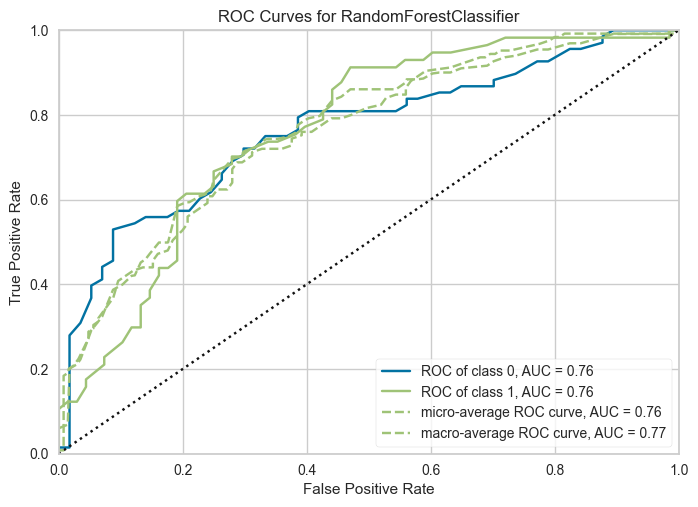

In [10]:
plot_model(best, plot='auc')

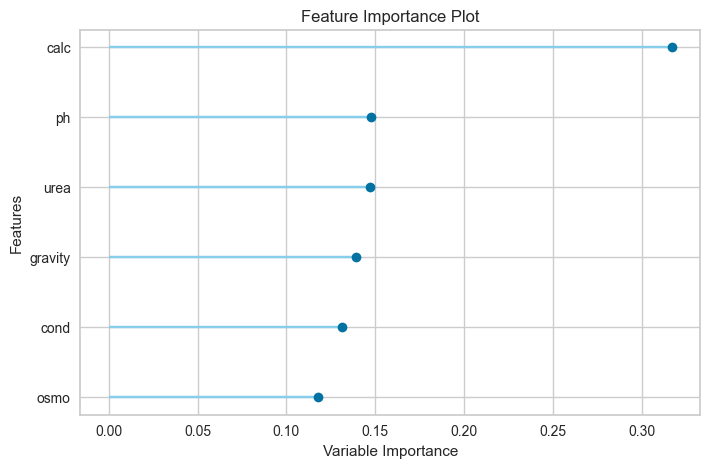

In [11]:
plot_model(best, plot='feature')

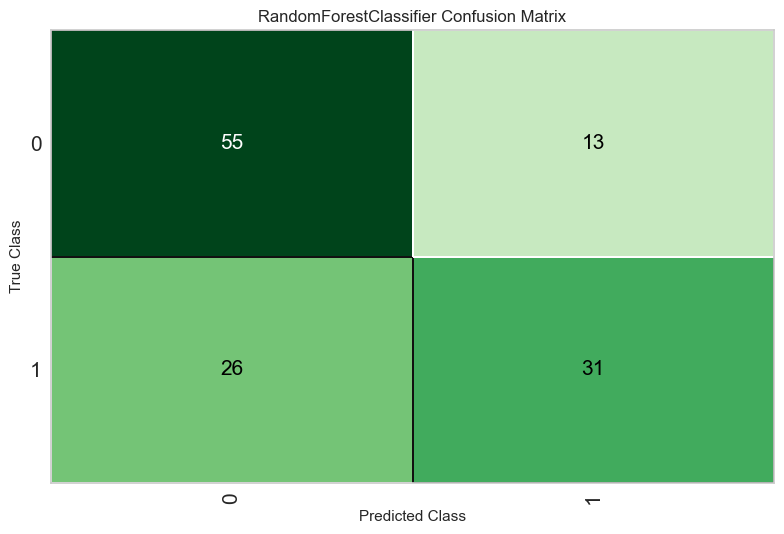

In [12]:
plot_model(best, plot='confusion_matrix')

# Hyperparameters Tuning

In [13]:
def rf(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
          
    model = RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [14]:
def lr(trial):
    C = trial.suggest_loguniform('C', 0.001, 1000)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'liblinear', 'sag', 'saga'])
    
    if solver=='sag' or solver=='newton-cg':
        penalty = 'l2'
        multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
    elif solver=='liblinear':
        multi_class = 'ovr'
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        if penalty==1:
            l1_ratio = trial.suggest_float(0, 1)
    elif solver=='saga':
        multi_class = trial.suggest_categorical('multi_class', ['ovr', 'multinomial'])
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        if penalty==1:
            l1_ratio = trial.suggest_float(0, 1)
          
    model = LogisticRegression(
        C=C,
        penalty = penalty,
        solver=solver,
        multi_class=multi_class
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [15]:
def lda(trial):
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
          
    model = LinearDiscriminantAnalysis(
        solver=solver
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [16]:
def et(trial):
    max_depth = trial.suggest_int('max_depth', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])

          
    model = ExtraTreesClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        max_features=max_features
    )
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [17]:
# def nb(trial):
#     var_smoothing  = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-3)
          
#     model = GaussianNB(
#         var_smoothing=var_smoothing
#     )
    
#     model.fit(X, y)
    
#     cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
#     return np.mean(cv_scores)

In [28]:
def gbc(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0)
    }
    
    model = GradientBoostingClassifier(**params)
    
    model.fit(X, y)
    
    cv_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kf)
    
    return np.mean(cv_scores)

In [19]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(rf, n_trials=100)
study.best_params

[I 2023-04-16 19:18:06,899] A new study created in memory with name: no-name-9a7a3040-ad27-4218-af35-cd165e65635e


{'max_depth': 38,
 'n_estimators': 392,
 'min_samples_leaf': 4,
 'min_samples_split': 61}

In [20]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lr, n_trials=100)
study.best_params

{'C': 5.774981378773462,
 'solver': 'saga',
 'multi_class': 'ovr',
 'penalty': 'l2'}

In [21]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(lda, n_trials=100)
study.best_params

{'solver': 'lsqr'}

In [22]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(et, n_trials=100)
study.best_params

{'max_depth': 79,
 'n_estimators': 372,
 'min_samples_leaf': 3,
 'min_samples_split': 49,
 'max_features': 'auto'}

In [24]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(nb, n_trials=100)
# study.best_params

In [26]:
# study = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(lightgbm, n_trials=100)
# study.best_params

In [29]:
study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(gbc, n_trials=100)
study.best_params

{'n_estimators': 498,
 'learning_rate': 0.014211310691951487,
 'max_depth': 1,
 'min_samples_split': 7,
 'min_samples_leaf': 7,
 'subsample': 0.46003560244834774}

In [31]:
rf_params = {
    'max_depth': 38,
    'n_estimators': 392,
    'min_samples_leaf': 4,
    'min_samples_split': 61
}

lr_params = {
    'C': 5.774981378773462,
    'solver': 'saga',
    'multi_class': 'ovr',
    'penalty': 'l2'
}

et_params = {
    'max_depth': 79,
    'n_estimators': 372,
    'min_samples_leaf': 3,
    'min_samples_split': 49,
    'max_features': 'auto'
}

lda_params = {
    'solver': 'lsqr'
}

gbc_params = {
    'n_estimators': 498,
    'learning_rate': 0.014211310691951487,
    'max_depth': 1,
    'min_samples_split': 7,
    'min_samples_leaf': 7,
    'subsample': 0.46003560244834774
}

# Bagging Ensemble

In [32]:
rf_model = RandomForestClassifier(**rf_params)
lda_model = LinearDiscriminantAnalysis(**lda_params)
lr_model = LogisticRegression(**lr_params)
gbc_model = GradientBoostingClassifier(**gbc_params)
et_model = ExtraTreesClassifier(**et_params)

In [43]:
final_model = VotingClassifier(estimators=[('rf', rf_model),
                                           ('lda', lda_model),
                                           ('lr', lr_model), 
                                           ('gbc', gbc_model),
                                           ('et', et_model)], 
                                 voting='soft')

# Evaluate

In [44]:
results_ensemble = []

r_ensemble = cross_val_score(final_model, X, y, scoring='roc_auc')
results_ensemble.append(r_ensemble)
print(f'Accuracy: {np.mean(results_ensemble).round(4)}')

Accuracy: 0.8086


# Model Training

In [45]:
final_model.fit(X, y)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=38,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=4,
                                                     min_samples_split=61,
                                                     min_weight_fraction_leaf=0.0,
         

# Prediction

In [47]:
final_predictions = final_model.predict(test[['cond', 'calc']])

submission = pd.concat([pd.Series(test.index), pd.Series(final_predictions, name='target')], axis=1)
submission

,id,target
0,414,0
1,415,0
2,416,1
3,417,0
4,418,0
...,...,...
271,685,1
272,686,0
273,687,1
274,688,0


# Submission

In [48]:
submission.to_csv('submission_ensemble_model_2_features.csv', index=False)